/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cuda


/tmp/ipykernel_42/663534729.py:59: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_42/663534729.py:60: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_42/663534729.py:61: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


tensor([1040, 1041, 1041, 1042])
tensor([1041, 1042, 1042, 1043])
tensor([ 999, 1000, 1000, 1001, 1001, 1001, 1002, 1002, 1003, 1004, 1005, 1042,
        1042, 1043, 1043, 1044, 1044])
tensor([ 996,  997,  998,  998,  999, 1000, 1001, 1001, 1002, 1002, 1003, 1003,
        1004, 1004, 1004, 1005, 1005, 1006, 1006, 1007, 1043, 1044, 1044, 1045,
        1045, 1046])
tensor([ 988,  989,  990,  991,  992,  993,  994,  994,  995,  996, 1007, 1008,
        1008, 1009, 1009, 1044, 1045, 1045, 1046, 1046, 1047, 1047])
tensor([ 989,  990,  991,  991,  992, 1009, 1010, 1011, 1011, 1046, 1047, 1047,
        1047, 1048, 1048, 1049])
tensor([1010, 1011, 1011, 1047, 1048, 1048, 1049, 1049, 1050])
tensor([1010, 1011, 1011, 1049, 1050, 1050, 1051, 1051, 1052, 1052, 1053])
tensor([1010, 1010, 1011, 1011, 1011, 1012, 1012, 1051, 1051, 1051, 1052, 1052,
        1053, 1053, 1053, 1054, 1054, 1054, 1055, 1055, 1055, 1056, 1056, 1057,
        1103, 1103, 1103, 1103, 1104, 1104, 1104])
tensor([1010, 1010, 101

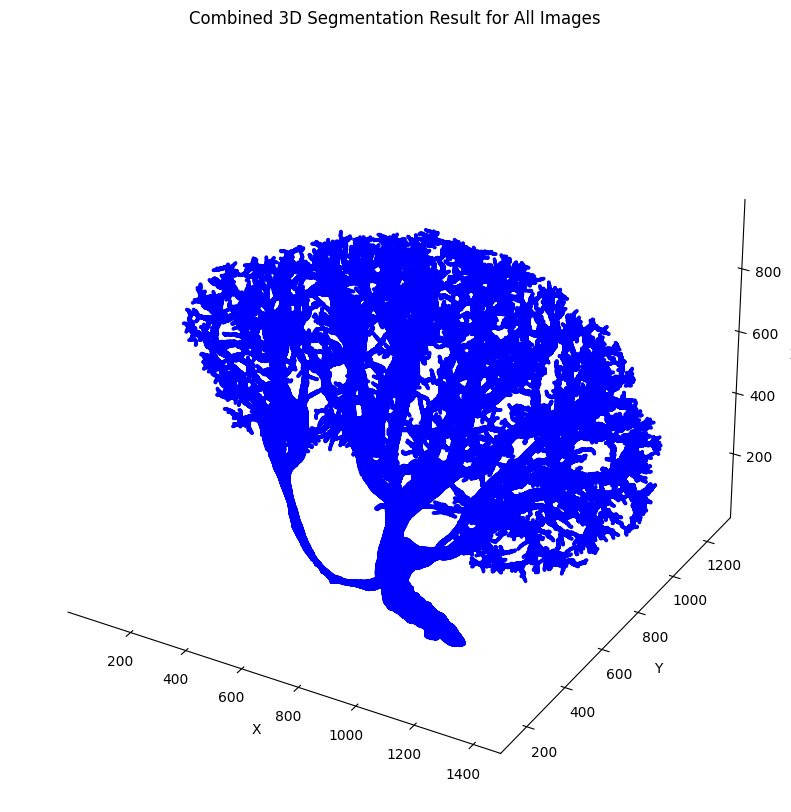

In [1]:
import os
import tifffile
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from skimage import transform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def load_and_resize_kidney_images(image_folder_path, target_size=(128, 128)):
    image_files = sorted([file for file in os.listdir(image_folder_path) if file.endswith(".tif")])
    image_data = []
    for file in image_files:
        image = tifffile.imread(os.path.join(image_folder_path, file)).astype(np.float32)
        resized_image = transform.resize(image, target_size, mode='constant')
        image_data.append(resized_image)
    return torch.from_numpy(np.stack(image_data))

image_folder_path = r'/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images'
data = load_and_resize_kidney_images(image_folder_path, target_size=(128, 128))
data = data.unsqueeze(1).float()  # Add channel dimension and convert to float
labels = torch.from_numpy(np.random.randint(0, 2, size=data.shape)).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = data.to(device)
labels = labels.to(device)

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, pin_memory=True)

labels_folder_path = r'/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels'  # Adjust the path accordingly
label_images = []
for file in sorted(os.listdir(labels_folder_path)):
    if file.endswith(".tif"):
        label_image = tifffile.imread(os.path.join(labels_folder_path, file))
        label_images.append(torch.from_numpy(label_image).float())

batch_size = 1000
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Remove grid background
ax.grid(False)

# Set background color to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set axis labels color to black
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.zaxis.label.set_color('black')

# Set tick labels color to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.tick_params(axis='z', colors='black')

for batch_start in range(0, len(label_images), batch_size):
    # Combine a batch of images into one 3D tensor
    predicted_labels_batch = torch.stack(label_images[batch_start:batch_start + batch_size], dim=0)
    predicted_labels_batch = predicted_labels_batch.to(device)
    
    # Iterate over each image's segmentation result in the batch
    for i in range(predicted_labels_batch.shape[0]):
        # Extract coordinates of non-zero values (assuming binary segmentation)
        non_zero_coords = predicted_labels_batch[i].nonzero()
        
        # Check if there are non-zero values before attempting to unpack
        if non_zero_coords.numel() > 0:
            if non_zero_coords.dim() == 2:
                x, y = non_zero_coords.unbind(1)
                z = torch.full_like(x, fill_value=i + batch_start)  # Use the image index as the z-coordinate
            elif non_zero_coords.dim() == 1:
                x, y = non_zero_coords.unbind(0)
                z = torch.full_like(x, fill_value=i + batch_start)  # Use the image index as the z-coordinate
            else:
                x, y, z = non_zero_coords.unbind(1)
            
            # Scatter plot with blue color, marker size, and transparency
            print(x.cpu())
            ax.scatter(x.cpu(), y.cpu(), z.cpu(), c='blue', marker='o', s=2, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined 3D Segmentation Result for All Images')

# Enable interactive mode for plot rotation
plt.ion()
plt.show()
